In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\fahee\AppData\Local\Temp\ipykernel_22264\909003939.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


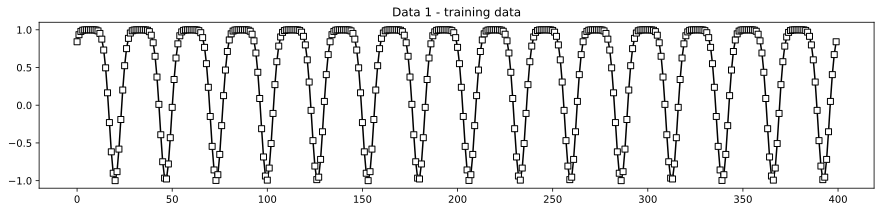

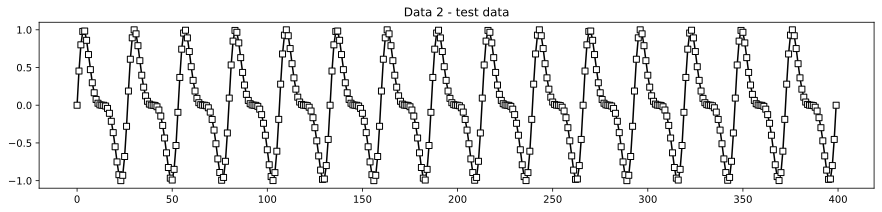

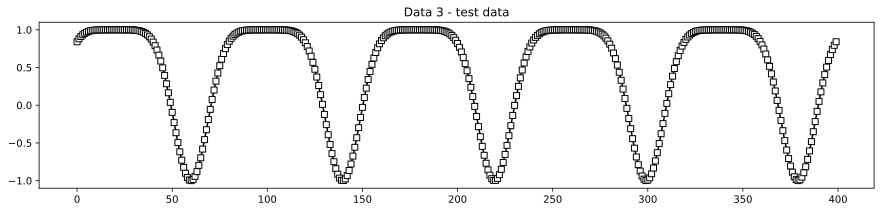

In [35]:
# make the data
N = 400

# data 1
time1 = torch.linspace(0, 30 * np.pi, N)    # t : 0->30pi
data1 = torch.sin(time1 + torch.cos(time1)) # sin(t+cos(t)

# data 2
time2 = torch.linspace(0, 30 * np.pi, N)    # t : 0->30pi
data2 = torch.sin(time2 + torch.sin(time2)) # sin(t+sin(t))

# data 3
time3 = torch.linspace(0, 10 * np.pi, N)    # t : 0->10pi
data3 = torch.sin(time3 + torch.cos(time3)) # sin(t+cos(t))

plt.figure(figsize=(15, 3))
plt.plot(data1, "ks-", label="data1", markerfacecolor="w")
plt.title("Data 1 - training data")

plt.figure(figsize=(15, 3))
plt.plot(data2, "ks-", label="data2", markerfacecolor="w")
plt.title("Data 2 - test data")

plt.figure(figsize=(15, 3))
plt.plot(data3, "ks-", label="data2", markerfacecolor="w")
plt.title("Data 3 - test data")

plt.show()

In [36]:
# network parameters
input_size = 1  # "channels" of data
num_hidden = 9  # breadth of model (number of units in hidden layers)
num_layers = 1  # depth of model (number of "stacks" of hidden layers)
seqlength = 30  # number of datapoints used for learning in each segment
batchsize = 1  # Note: the training code is actually hard-coded to organize data into batchsize=1

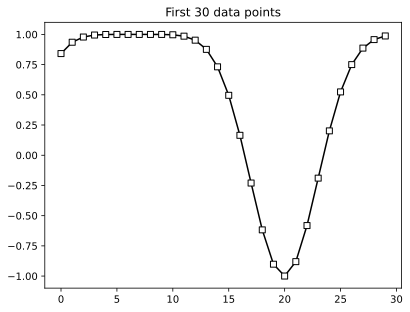

In [37]:
# is 30 enough data?
plt.plot(data1[:seqlength], "ks-", markerfacecolor="w")
plt.title(f"First {seqlength} data points")
plt.show()

In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x, h):

        # run through the RNN layer
        y, hidden = self.rnn(x, h)

        # and the output (linear) layer
        y = self.out(y)

        return y, hidden.detach()

In [39]:
# create an instance of the model and inspect
net = RNN(input_size, num_hidden, num_layers)

X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X, None)  # None is for empty hidden state input
print(X.shape)
print(
    y.shape
)  # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


In [42]:
# test the model with some data, just to see if it runs
somedata = data1[:seqlength].view(seqlength,1,1)
y = net(somedata,None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data1[seqlength].view(1,1))

tensor(0.1196, grad_fn=<MseLossBackward0>)

In [44]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = RNN(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seglosses = []
    segacc = []

    for timei in range(N - seqlength):

        # grab a snippet of data
        X = data1[timei : timei + seqlength].view(seqlength, 1, 1)
        y = data1[timei + seqlength].view(1, 1)

        # forward pass and loss
        yHat, hiddenstate = net(X, hiddenstate)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y)  # compare final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

    # average losses from this epoch
    losses[epochi] = np.mean(seglosses)

    msg = f"Finished epoch {epochi+1}/{numepochs}"
    sys.stdout.write("\r" + msg)

Finished epoch 30/30

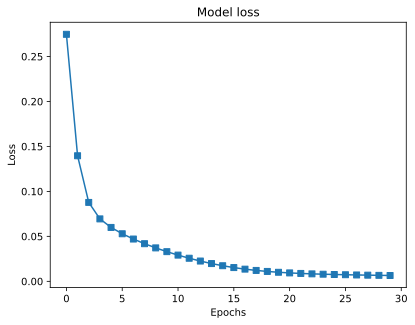

In [45]:
# ee how the model did!

plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

In [74]:
# now test the network with data 1
yHat = np.zeros(N)
yHat[:] = np.nan

for timei in range(N - seqlength):

    # grab a snippet of data 1
    X = data1[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X, None)
    yHat[timei + seqlength] = yy[-1]

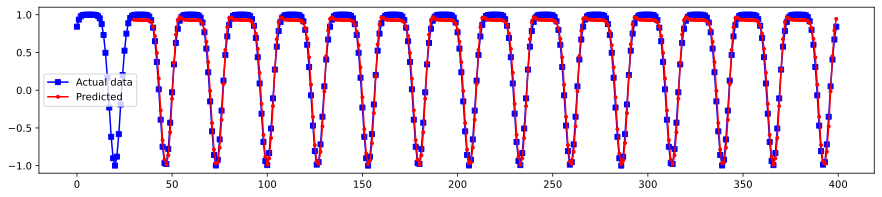

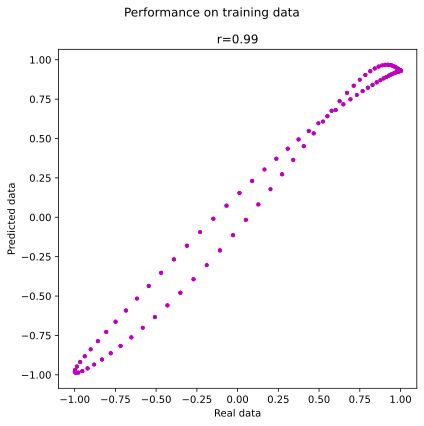

In [75]:
## plot!
plt.figure(figsize=(15, 3))
plt.plot(data1, "bs-", label="Actual data", markersize=5)
plt.plot(yHat, "ro-", label="Predicted", markersize=3)
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
r = np.corrcoef(data1[seqlength:], yHat[seqlength:])
plt.plot(data1[seqlength:], yHat[seqlength:], "mo", markersize=3)
plt.xlabel("Real data")
plt.ylabel("Predicted data")
plt.title(f"r={r[0,1]:.2f}")

plt.suptitle("Performance on training data")
plt.tight_layout()
plt.show()

In [76]:
# now test the network with data 2
yHat = np.zeros(N)
yHat[:] = np.nan

for timei in range(N - seqlength):

    # grab a snippet of data 2
    X = data2[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X, None)
    yHat[timei + seqlength] = yy[-1]

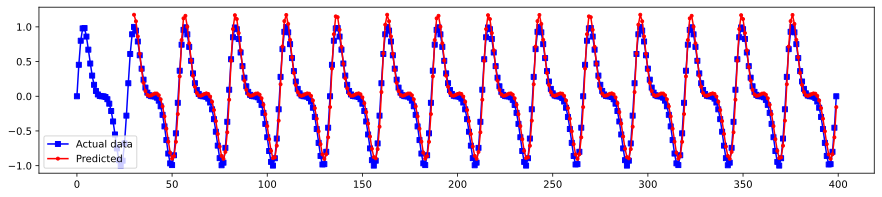

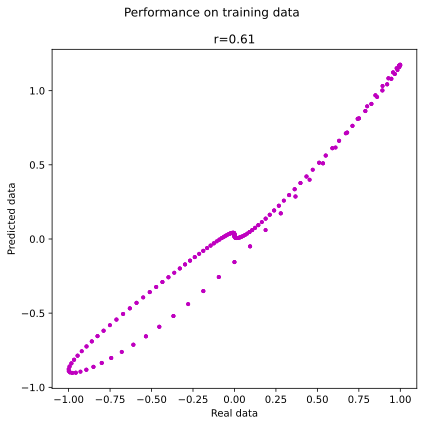

In [77]:
## plot!
plt.figure(figsize=(15, 3))
plt.plot(data2, "bs-", label="Actual data", markersize=5)
plt.plot(yHat, "ro-", label="Predicted", markersize=3)
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
r = np.corrcoef(data1[seqlength:], yHat[seqlength:])
plt.plot(data2[seqlength:], yHat[seqlength:], "mo", markersize=3)
plt.xlabel("Real data")
plt.ylabel("Predicted data")
plt.title(f"r={r[0,1]:.2f}")

plt.suptitle("Performance on training data")
plt.tight_layout()
plt.show()

In [78]:
# now test the network with data 3
yHat = np.zeros(N)
yHat[:] = np.nan

for timei in range(N - seqlength):

    # grab a snippet of data 2
    X = data3[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X, None)
    yHat[timei + seqlength] = yy[-1]

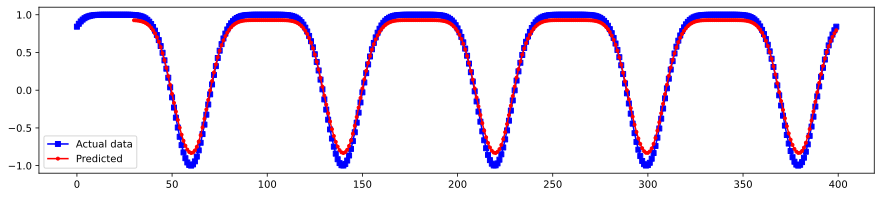

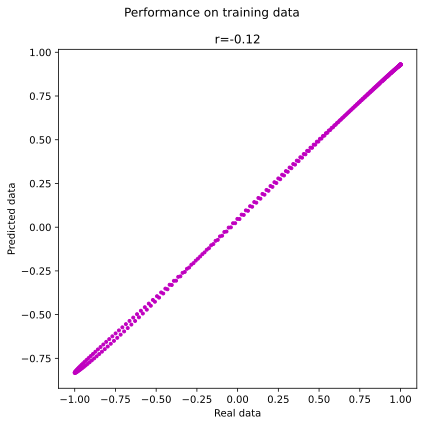

In [80]:
## plot!
plt.figure(figsize=(15, 3))
plt.plot(data3, "bs-", label="Actual data", markersize=5)
plt.plot(yHat, "ro-", label="Predicted", markersize=3)
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
r = np.corrcoef(data1[seqlength:], yHat[seqlength:])
plt.plot(data3[seqlength:], yHat[seqlength:], "mo", markersize=3)
plt.xlabel("Real data")
plt.ylabel("Predicted data")
plt.title(f"r={r[0,1]:.2f}")

plt.suptitle("Performance on training data")
plt.tight_layout()
plt.show()